## **Project: Sentiment Analysis on Amazon Product Reviews**




In [ ]:
FIRST_NAME = "Muthu"
LAST_NAME = "Selvam"
STUDENT_ID = "801276057"

In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Create Amazon Customer Reviews DataFrame from JSON objects

In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('amazon_product_reviews.json.gz')

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [ ]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

reviewerID        0   
asin              0   
reviewerName      3519
helpful           0   
reviewText        0   
overall           0   
summary           0   
unixReviewTime    0   
reviewTime        0   
dtype: int64

In [ ]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

5.0    108664
4.0    39993 
3.0    21439 
1.0    13279 
2.0    11064 
Name: overall, dtype: int64


5.0    55.885908
4.0    20.568404
3.0    11.026080
1.0    6.829391 
2.0    5.690216 
Name: overall, dtype: float64

## Separate positive and negative reviews for analysis

In [ ]:
df_negative_reviews = df[df['overall']<3].iloc[:100000]
df_positive_reviews = df[df['overall']>3].iloc[:200000]

In [ ]:
df_new = df.iloc[:100]
df_new.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


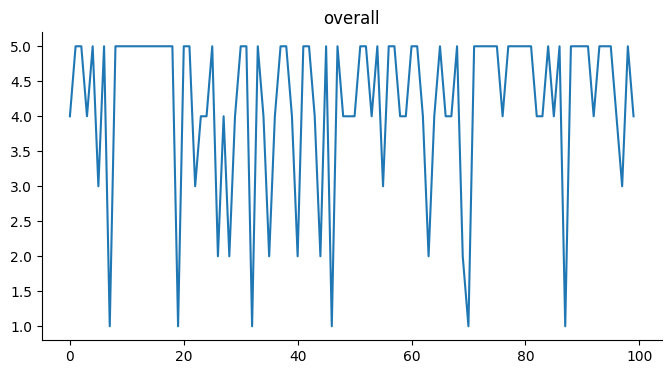

In [ ]:
# @title overall

from matplotlib import pyplot as plt
df_new['overall'].plot(kind='line', figsize=(8, 4), title='overall')
plt.gca().spines[['top', 'right']].set_visible(False)

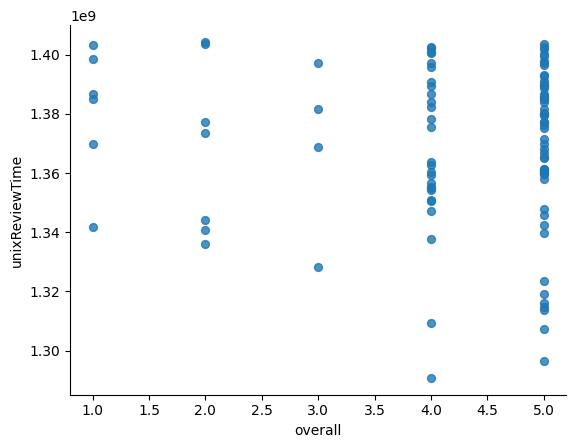

In [ ]:
# @title overall vs unixReviewTime

from matplotlib import pyplot as plt
df_new.plot(kind='scatter', x='overall', y='unixReviewTime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Review Text PreProcssing Function Definitions

In [ ]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [ ]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)

    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)

## Create Negative Reviews WordCloud

In [26]:
tmp = list()
num_rows = min(100000, len(df_negative_reviews))  # Ensure we don't exceed the number of rows
for i in range(num_rows):
    tmp.append(cleanme(df_negative_reviews.iloc[i,:]['reviewText']))

tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

df_negative_reviews_new = df_negative_reviews.reset_index()
df_negative_reviews_new = pd.concat([df_negative_reviews_new,tmp], axis=1)
df_negative_reviews_new = df_negative_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_negative_reviews_new.head()


,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,1.0,it worked for the first week then it only charge my phone to 20%. it is a waste of money.,not a good Idea,7,worked first week charge phone waste money,first
1,1.0,It worked great for the first couple of weeks then it just stopped completely.. so basically a small waste of money.,Horrible,11,worked great first couple weeks stopped completely basically small waste money,great first small
2,2.0,I am disappointed that the 1A didn't work with my iPad. That's what I get for buying a cheap adapter.,This doesn't work with my iPad.,8,disappointed not work ipad get buying cheap adapter,cheap
3,2.0,After a week only one side works,Two Stars,4,week one side works,
4,1.0,"Only works one side at a time. When you connect two cables, one side stop working and also overheated burning the fuses. I purchased two of them and it's the same problem. Cheap and bad quality.","don't waste your money, pay more and buy one at Walgreen s.",21,works one side time connect two cables one side stop working also overheated burning fuses purchased two problem cheap bad quality,same bad


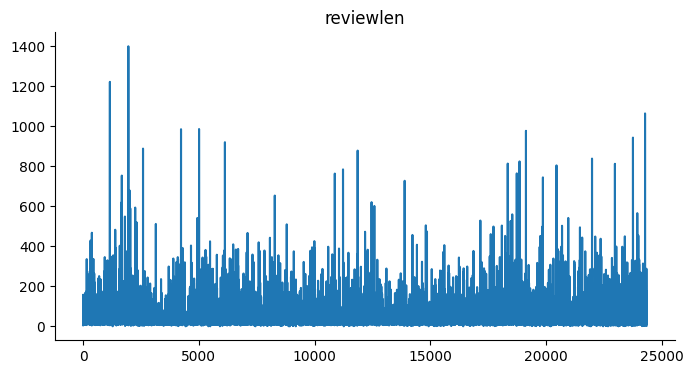

In [27]:
# @title reviewlen

from matplotlib import pyplot as plt
df_negative_reviews_new['reviewlen'].plot(kind='line', figsize=(8, 4), title='reviewlen')
plt.gca().spines[['top', 'right']].set_visible(False)

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_negative_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(40)

[nltk_data] Downloading package wordnet to /root/nltk_data...


[(('would', 'not', 'recommend'), 702),
 (('not', 'waste', 'money'), 329),
 (('not', 'fit', 'phone'), 291),
 (('could', 'not', 'get'), 273),
 (('screen', 'protector', 'not'), 244),
 (('not', 'recommend', 'product'), 240),
 (('case', 'not', 'fit'), 230),
 (('would', 'not', 'buy'), 225),
 (('not', 'work', 'well'), 181),
 (('phone', 'would', 'not'), 162),
 (('not', 'charge', 'phone'), 161),
 (('not', 'last', 'long'), 150),
 (('not', 'worth', 'money'), 150),
 (('not', 'recommend', 'case'), 149),
 (('not', 'recommend', 'anyone'), 146),
 (('would', 'not', 'charge'), 141),
 (('not', 'fit', 'well'), 129),
 (('not', 'work', 'not'), 125),
 (('would', 'not', 'work'), 124),
 (('guess', 'get', 'pay'), 112),
 (('not', 'buy', 'not'), 111),
 (('would', 'not', 'stay'), 110),
 (('not', 'hold', 'charge'), 108),
 (('samsung', 'galaxy', 'note'), 107),
 (('case', 'would', 'not'), 101),
 (('not', 'buy', 'product'), 96),
 (('would', 'not', 'fit'), 95),
 (('not', 'waste', 'time'), 93),
 (('waste', 'time', 'mone

In [30]:
d = {}
for key, value in fdist.items() :
    d["_".join(key)] = value

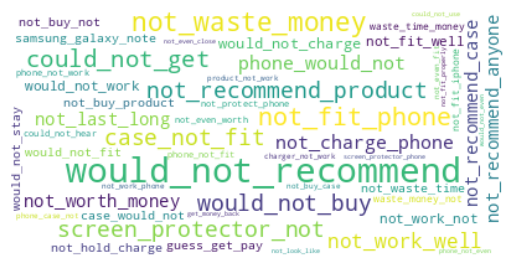

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Bigrams_frequent_words.png")

## Create Positive Reviews WordCloud

In [ ]:
tmp = list()
for i in range(150000):
    tmp.append(cleanme(df_positive_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_positive_reviews_new = df_positive_reviews.reset_index()
df_positive_reviews_new = pd.concat([df_positive_reviews_new,tmp], axis=1)
df_positive_reviews_new = df_positive_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_positive_reviews_new.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_positive_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]

bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(30)

In [ ]:
d = {}
for key, value in fdist.items() :
    d["_".join(key)] = value

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Positive_Reviews.png")